# **Understanding Risk Score Drivers Using Feature Correlations and Predictive Modeling**

## Team Members:
- Gavin Robertson
- Aaron Ravela
- Nick Wilson

Instructor: Dr. Saquer

Date: December 10, 2025

College: Missouri State University

# Imports(start here)

In [1]:
!pip install catboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import seaborn as sns

In [3]:
#Found on Kaggle
#https://www.kaggle.com/datasets/mohankrishnathalla/medical-insurance-cost-prediction

raw = pd.read_csv('https://raw.githubusercontent.com/Abled773/HI-Risk-Prediction-and-Analysis/main/medical_insurance.csv')

# Understanding the Data

In [4]:
# 54 Columns
raw.columns

Index(['person_id', 'age', 'sex', 'region', 'urban_rural', 'income',
       'education', 'marital_status', 'employment_status', 'household_size',
       'dependents', 'bmi', 'smoker', 'alcohol_freq', 'visits_last_year',
       'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs',
       'medication_count', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c',
       'plan_type', 'network_tier', 'deductible', 'copay', 'policy_term_years',
       'policy_changes_last_2yrs', 'provider_quality', 'risk_score',
       'annual_medical_cost', 'annual_premium', 'monthly_premium',
       'claims_count', 'avg_claim_amount', 'total_claims_paid',
       'chronic_count', 'hypertension', 'diabetes', 'asthma', 'copd',
       'cardiovascular_disease', 'cancer_history', 'kidney_disease',
       'liver_disease', 'arthritis', 'mental_health', 'proc_imaging_count',
       'proc_surgery_count', 'proc_physio_count', 'proc_consult_count',
       'proc_lab_count', 'is_high_risk', 'had_major_procedure'],
      

In [5]:
raw.shape

(100000, 54)

In [6]:
raw.head()

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
0,75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,...,0,1,0,1,0,2,0,1,0,0
1,80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,...,0,1,1,0,0,1,0,1,1,0
2,19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,...,0,0,1,1,0,2,1,0,1,0
3,76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,...,0,0,0,1,0,0,1,0,0,0
4,92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,...,0,1,0,2,0,1,1,0,1,0


In [7]:
# Data dTypes are well defined and only have 10 object Dtypes
# Some of the objects can be converted to categorical later on for consistency

raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 54 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   person_id                    100000 non-null  int64  
 1   age                          100000 non-null  int64  
 2   sex                          100000 non-null  object 
 3   region                       100000 non-null  object 
 4   urban_rural                  100000 non-null  object 
 5   income                       100000 non-null  float64
 6   education                    100000 non-null  object 
 7   marital_status               100000 non-null  object 
 8   employment_status            100000 non-null  object 
 9   household_size               100000 non-null  int64  
 10  dependents                   100000 non-null  int64  
 11  bmi                          100000 non-null  float64
 12  smoker                       100000 non-null  object 
 13  

In [8]:
raw.describe(include="all")

,person_id,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
count,100000.000000,100000.000000,100000,100000,100000,1.000000e+05,100000,100000,100000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000
unique,NaN,NaN,3,5,3,NaN,6,4,4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Female,South,Urban,NaN,Bachelors,Married,Employed,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,49193,28029,60019,NaN,27996,53252,55269,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,50000.500000,47.521500,NaN,NaN,NaN,4.987390e+04,NaN,NaN,NaN,2.430900,...,0.014770,0.108310,0.130140,0.508530,0.158690,0.508390,0.50933,0.509140,0.367810,0.169700
std,28867.657797,15.988752,NaN,NaN,NaN,4.680021e+04,NaN,NaN,NaN,1.075126,...,0.120632,0.310773,0.336459,0.749755,0.463562,0.747218,0.75363,0.750455,0.482212,0.375371
min,1.000000,0.000000,NaN,NaN,NaN,1.100000e+03,NaN,NaN,NaN,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,25000.750000,37.000000,NaN,NaN,NaN,2.110000e+04,NaN,NaN,NaN,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,50000.500000,48.000000,NaN,NaN,NaN,3.620000e+04,NaN,NaN,NaN,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,75000.250000,58.000000,NaN,NaN,NaN,6.220000e+04,NaN,NaN,NaN,3.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000


In [9]:
# This is a strong dataset with no null values in all of the columns besides alcohol_freq
raw.isna().sum()


person_id                      0
age                            0
sex                            0
region                         0
urban_rural                    0
income                         0
education                      0
marital_status                 0
employment_status              0
household_size                 0
dependents                     0
bmi                            0
smoker                         0
alcohol_freq                   0
visits_last_year               0
hospitalizations_last_3yrs     0
days_hospitalized_last_3yrs    0
medication_count               0
systolic_bp                    0
diastolic_bp                   0
ldl                            0
hba1c                          0
plan_type                      0
network_tier                   0
deductible                     0
copay                          0
policy_term_years              0
policy_changes_last_2yrs       0
provider_quality               0
risk_score                     0
annual_med

In [10]:
# No Duplicate Rows
raw.duplicated().sum()

0

## Summary of Structure Analysis
From the Structure analysis, we can see the data:

 * Has a size of 5400000(100000 x 54)
 * Has well defined data types (13 floats, 31 ints, 10 objects)
 * All columns do not have null values and exist in all rows except for alchohol frequency
 * No duplicate rows








---



# Data Cleaning

Because this data is so well-defined, it needs very little cleaning in order to be operational. Still there are some tasks that we can do:

 * Manage missing alchohol frequency data
 * Create a table suitable for reading
 * Create a table suitable for analysis

## Changing Object Data Types

In [11]:
# show all object dType columns and put them in a list
obj_cols = list(raw.select_dtypes(include='object').columns)
obj_cols

['sex',
 'region',
 'urban_rural',
 'education',
 'marital_status',
 'employment_status',
 'smoker',
 'alcohol_freq',
 'plan_type',
 'network_tier']

In [12]:
#see the range of data of object data types
for col in obj_cols:
    print(f"Unique values for column '{col}': {raw[col].unique()}")

Unique values for column 'sex': ['Female' 'Male' 'Other']
Unique values for column 'region': ['North' 'Central' 'West' 'South' 'East']
Unique values for column 'urban_rural': ['Suburban' 'Urban' 'Rural']
Unique values for column 'education': ['Doctorate' 'No HS' 'HS' 'Some College' 'Masters' 'Bachelors']
Unique values for column 'marital_status': ['Married' 'Single' 'Divorced' 'Widowed']
Unique values for column 'employment_status': ['Retired' 'Employed' 'Self-employed' 'Unemployed']
Unique values for column 'smoker': ['Never' 'Current' 'Former']
Unique values for column 'alcohol_freq': ['None' 'Weekly' 'Daily' 'Occasional']
Unique values for column 'plan_type': ['PPO' 'POS' 'HMO' 'EPO']
Unique values for column 'network_tier': ['Bronze' 'Gold' 'Platinum' 'Silver']


### Manage Missing Alcohol Frequency Data

Before we can deal with Alchohol frequency as a data type, we must manage the null values in this column. So let us look at the reasoning for these null values.

**Important** When testing, we noticed that on some devices the None values transfer properly as "None" others the None values transfer as Null. If you see that there are null values, do not worry, everything should still work!

In [13]:
raw["alcohol_freq"].head(10)

0          None
1        Weekly
2          None
3          None
4         Daily
5         Daily
6    Occasional
7        Weekly
8          None
9        Weekly
Name: alcohol_freq, dtype: object

We can see that in the first 10 rows. There is no row that has a defined none category. Due to this, we can assume that null values mean that the patient does not consume alcohol.

For now we will leave it be and handle it when converting all object data types.

Now that we understand the object data, it's time to convert the data for correlation and regression analysis. Note that some columns will be modified once we get to modeling risk_score. This is because some of the columns that have no numerical data and no rankings cannot be correlated properly without one-hotting everything.

## Creating an Optimized Readable Data Table

In [14]:
# Copied raw table so we can create a clean table without affecting the original
data = raw.copy()

# Creating a clean READABLE table

# handle na alcohol values
data["alcohol_freq"] = data["alcohol_freq"].fillna("None")

# convert to category data types
data[obj_cols] = data[obj_cols].astype('category')

data['alcohol_freq'].value_counts()
data[obj_cols].info(0)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   sex                100000 non-null  category
 1   region             100000 non-null  category
 2   urban_rural        100000 non-null  category
 3   education          100000 non-null  category
 4   marital_status     100000 non-null  category
 5   employment_status  100000 non-null  category
 6   smoker             100000 non-null  category
 7   alcohol_freq       100000 non-null  category
 8   plan_type          100000 non-null  category
 9   network_tier       100000 non-null  category
dtypes: category(10)
memory usage: 978.5 KB


## Creating a Analysis-Ready Table

In order for the categorical data to be readable by the correlation methods and regression models, they must be reperesented in a numerical format, whether that be by bools, ints or floats. We will go in further detail on our encoding methods after in the conclusion.

For the categorical data that does not have an order, we use one-hot encoding.

In [15]:
# one-hot all nominal values

# Create a copy of clean data, so we can create the analysis table safely.
transfer = data.copy()


nominal_cols = ["region","marital_status","employment_status","sex", "plan_type", "urban_rural"]
one_hot_nom = pd.get_dummies(transfer[nominal_cols], drop_first=True)

analysis_data = pd.concat([transfer.drop(nominal_cols, axis=1), one_hot_nom], axis=1)

analysis_data.head()

,person_id,age,income,education,household_size,dependents,bmi,smoker,alcohol_freq,visits_last_year,...,employment_status_Retired,employment_status_Self-employed,employment_status_Unemployed,sex_Male,sex_Other,plan_type_HMO,plan_type_POS,plan_type_PPO,urban_rural_Suburban,urban_rural_Urban
0,75722,52,22700.0,Doctorate,3,1,27.4,Never,None,2,...,1,0,0,0,0,0,0,1,1,0
1,80185,79,12800.0,No HS,3,1,26.6,Never,Weekly,2,...,0,0,0,0,0,0,1,0,0,1
2,19865,68,40700.0,HS,5,3,31.5,Never,None,1,...,1,0,0,1,0,1,0,0,0,0
3,76700,15,15600.0,Some College,5,3,31.6,Never,None,0,...,0,1,0,1,0,1,0,0,1,0
4,92992,53,89600.0,Doctorate,2,0,30.5,Never,Daily,3,...,0,1,0,1,0,0,1,0,1,0


 For the categorical data that does have an order, we use ordinal encoding.

In [16]:
# Create Ordinal Map
ordinal_maps = {
    'smoker': {'Never' : 0, 'Former' : 1, 'Current' : 2},
    'alcohol_freq': {"None" : 0, 'Occasional' : 1, 'Weekly' : 2, 'Daily' : 3},
    'education': {'No HS' : 0, 'HS' : 1, 'Some College' : 2, 'Bachelors' : 3, 'Masters' : 4, 'Doctorate' : 5},
    'network_tier': {'Bronze' : 0, 'Silver' : 1, 'Gold' : 2, 'Platinum' : 3},
}

for col, mapping in ordinal_maps.items():
    analysis_data[col] = analysis_data[col].map(mapping).astype(int)


analysis_data[list(ordinal_maps.keys())].head(10)
analysis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 65 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   person_id                        100000 non-null  int64  
 1   age                              100000 non-null  int64  
 2   income                           100000 non-null  float64
 3   education                        100000 non-null  int64  
 4   household_size                   100000 non-null  int64  
 5   dependents                       100000 non-null  int64  
 6   bmi                              100000 non-null  float64
 7   smoker                           100000 non-null  int64  
 8   alcohol_freq                     100000 non-null  int64  
 9   visits_last_year                 100000 non-null  int64  
 10  hospitalizations_last_3yrs       100000 non-null  int64  
 11  days_hospitalized_last_3yrs      100000 non-null  int64  
 12  med

## Conclusion (**Assigning Tables**)

We have now created many tables used for different purposes. All of the existing tables' purposes will be listed below.

* raw

  The original imported table - is not cleaned.

* data
  
  This is a cleaned version of raw. It has converted null values in alcohol frequency to a defined "none". Converts all object data types to the category type.

  For visualization, please use this table.

* analysis_data

  This table is derived from the cleaned version. It encodes all category types into numeric data types that is readable for correlation and linear regression. **Note**, that this table is hard to read and not meant for the reader.
  
  Use this table for correlation and regression.


  Here is how it is encoded:

  * **Ordinal**
    
    These columns have a definitive ranking, so we can numerically rank these for analysis. The columns that are determined to be ordinal is smoker, alcohol_freq, education, education, and network_tier.

    Here is how they are organized:

    **smoker:**
    
    'Never' : 0, 'Former' : 1, 'Current' : 2
    
    **alcohol_freq:**
    
    'None' : 0, 'Occasional' : 1, 'Weekly' : 2, 'Daily' : 3
    
    **'education':**
    
    'No HS' : 0, 'HS' : 1, 'Some College' : 2, 'Bachelors' : 3, 'Masters' : 4, 'Doctorate' : 5
    
    **'network_tier':**

    'Bronze' : 0, 'Silver' : 1, 'Gold' : 2, 'Platinum' : 3

   * **Nominal**
   
   Nominal value has no ranking amongst the categories, because of this, all nominal values are one-hot encoded. One-hot encoding creates a boolean column for each unique value. This of course create a ton of columns. This makes the data very hard to read and performance intensive, but the computations can still be easily handled by modern cpu's.

   Here is the list of nominal values:
   
   "region",
   "marital_status",
   "employment_status",
   "sex",
   "plan_type",
   "urban_rural"

   Now that we have cleaned our data. We are able to easily visualize, correlate and model data.





# Data Analysis(Correlation/Visualization)

In this section we aim to coorelate many features and gain an understanding of how the data works. We will first create a correlation matrix, and create a table with only features that are strongly correlated to risk.

We will then get an understanding of risk_score using correlations and visualizations. Then we will look into features that are highly correlated to risk_score, or are interesting to look into.


In [17]:
#Remember this, as we will take a deeper look at risk_score_correlations again in the Data Analysis portion.
corr_matrix = analysis_data.corr(numeric_only=True)
risk_score_correlations = corr_matrix['risk_score']

#Create a table with only strong correlations, also remove is high risk and risk score.
#Remember this variable as we will use it later
strong_corr = risk_score_correlations[abs(risk_score_correlations) > 0.1].drop(index=["risk_score", "is_high_risk"])


## Risk


In [18]:
#Top 10 strongest correlating features
sorted_risk_score_correlations = strong_corr.sort_values(key=abs, ascending=False)
sorted_risk_score_correlations.head(10)

age                    0.720989
chronic_count          0.666014
systolic_bp            0.553843
diastolic_bp           0.379526
hypertension           0.346731
visits_last_year       0.313346
claims_count           0.311008
annual_medical_cost    0.305971
total_claims_paid      0.305782
monthly_premium        0.295860
Name: risk_score, dtype: float64

In [21]:
# There are no strong negative risk score correlations:
negative_risk_score_correlations = (strong_corr[strong_corr < 0].sort_values().head())

### High Risk?

High risk is a derived boolean attribute that is true if risk_score > 0.6

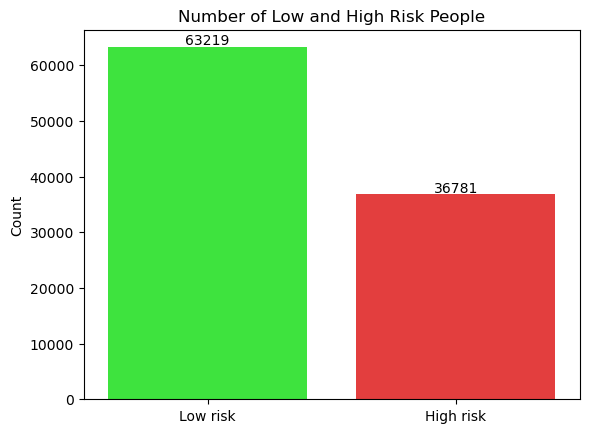

In [37]:
ax = sns.countplot(data=data, x='is_high_risk', palette=['#22ff22', '#ff2222'])
plt.ylabel('Count')
plt.xlabel(None)
plt.title('Number of Low and High Risk People')

ax.set_xticklabels(['Low risk', 'High risk'])

#adds the numbers on top
for p in plt.gca().patches:
    height = p.get_height()
    plt.text(p.get_x() + p.get_width()/2, height + 450, int(height), ha='center')

Mean risk score: 0.519849295


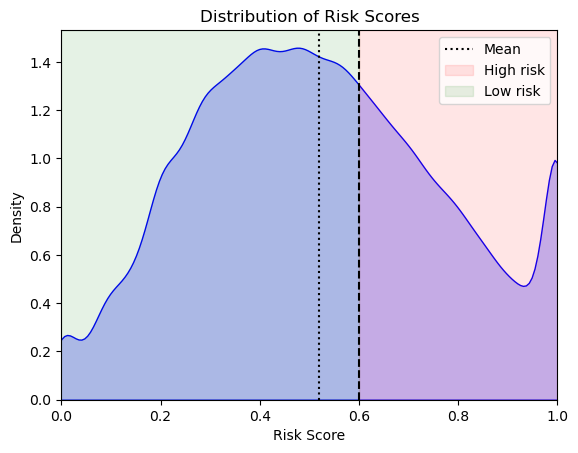

In [23]:
sns.kdeplot(data['risk_score'], fill=True, color='blue')
plt.xlabel('Risk Score')
plt.ylabel('Density')
plt.title('Distribution of Risk Scores')
#plt.axvline(x=0.6, linestyle='--', linewidth=2, label='High risk')
plt.xlim(0.0, 1.0)
plt.axvline(x=0.6, color='black', linestyle='--')

mean_riskscore = data['risk_score'].mean()
print(f'Mean risk score: {mean_riskscore}')
plt.axvline(x=mean_riskscore, color='black', linestyle=':', label='Mean')

plt.axvspan(xmin=0.6, xmax=plt.xlim()[1], alpha=0.1, color='red', label='High risk')
plt.axvspan(xmin=plt.xlim()[0], xmax=0.6, alpha=0.1, color='green', label='Low risk')

plt.legend()

## Age
Age has the highest correlation with risk score

In [ ]:
average_age = data['age'].mean()
average_age

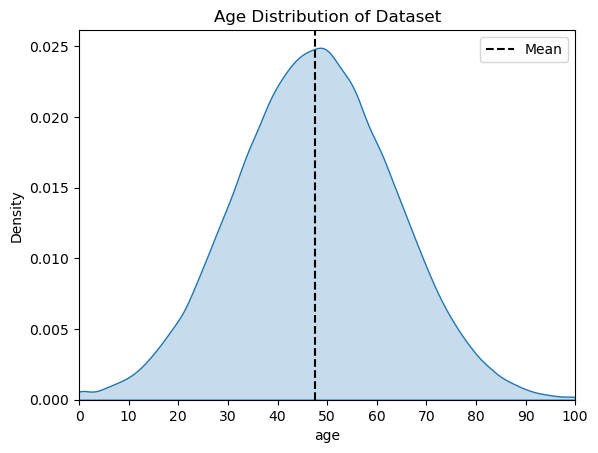

In [42]:
sns.kdeplot(data=data['age'], fill=True)
plt.title("Age Distribution of Dataset")
plt.xticks(range(0, 110, 10))
plt.xlim(0, 100)

plt.axvline(x=average_age, color='black', linestyle='--', label='Mean')
plt.legend()

(0.0, 100.0)

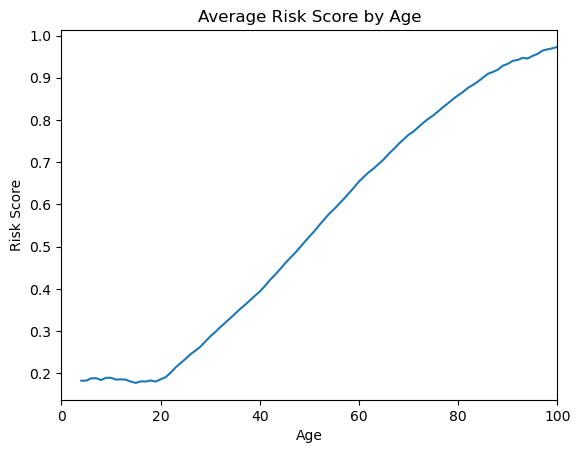

In [41]:
age_average_risk_score = data.groupby('age')['risk_score'].mean()
# Rolling average risk score of last 5 years of age
smoothed_age_average = age_average_risk_score.rolling(window=5).mean()
sns.lineplot(smoothed_age_average)
plt.title('Average Risk Score by Age')
plt.ylabel('Risk Score')
plt.xlabel('Age')
plt.xlim(0, 100)

In [40]:
# correlations with age
age_correlations = analysis_data.corr(numeric_only=True)['age']
irrelevant_age_cols = ['age', 'person_id', 'is_high_risk']
for col in irrelevant_age_cols:
    age_correlations.pop(col)
relevant_age_correlations = age_correlations[age_correlations > 0.1].sort_values(ascending=False)
relevant_age_correlations

risk_score             0.720989
systolic_bp            0.555174
diastolic_bp           0.304183
chronic_count          0.136148
annual_medical_cost    0.131166
annual_premium         0.127473
monthly_premium        0.127473
ldl                    0.110565
total_claims_paid      0.101717
Name: age, dtype: float64

Of the attributes we are looking at, blood pressure and number of chronic conditions are the main things that go up as you age that affect risk score

## Chronic Count

Defined as: The total number of chronic health conditions a person has, such as diabetes, hypertension, or asthma.

This means it encases an umbrella of health issues, so it figures that it would be highly correlating.

In [43]:
data['chronic_count'].value_counts()

0    46532
1    37579
2    13111
3     2452
4      316
5        9
6        1
Name: chronic_count, dtype: int64

In [44]:
#correlations with chronic count
cc_correlations = analysis_data.corr(numeric_only=True)['chronic_count']
irrelevant_age_cols = ['chronic_count', 'person_id', 'is_high_risk']
for col in irrelevant_age_cols:
    cc_correlations.pop(col)
relevant_age_correlations = cc_correlations[cc_correlations > 0.1].sort_values(ascending=False)
relevant_age_correlations.head(10)

risk_score           0.666014
hypertension         0.508786
claims_count         0.471865
visits_last_year     0.469252
mental_health        0.421865
medication_count     0.395701
arthritis            0.395137
total_claims_paid    0.366139
diabetes             0.354122
systolic_bp          0.334695
Name: chronic_count, dtype: float64

From this, we can see that people with a chronic count have a higher visit rate to the hospital. While this is obvious it is nice to see reflected in the correlations.

However, the definition of chronic_count includes conditions like diabetes or hypertension, so, if need be, we could assume that we could remove the chronic conditions to avoid multicolinearity.

Text(0.5, 0, 'Chronic Count')

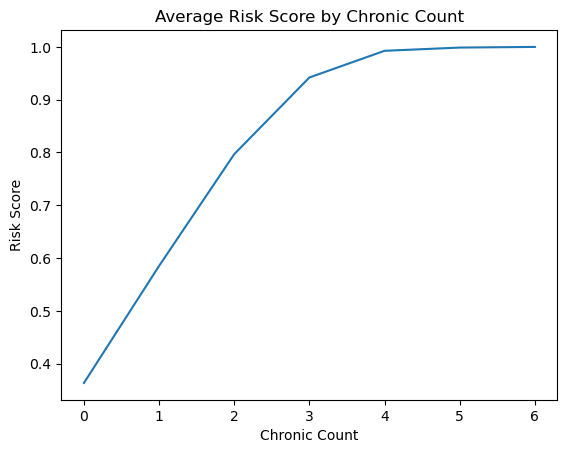

In [65]:
chronic_average_risk_score = data.groupby('chronic_count')['risk_score'].mean()
sns.lineplot(chronic_average_risk_score)
plt.title('Average Risk Score by Chronic Count')
plt.ylabel('Risk Score')
plt.xlabel('Chronic Count')

## BMI

Loosely correlated with risk, but is often attributed to many health problems.

In [66]:
bmi_correlations = analysis_data.corr(numeric_only=True)['bmi']
irrelevant_age_cols = ['bmi', 'person_id', 'is_high_risk']
for col in irrelevant_age_cols:
    bmi_correlations.pop(col)
relevant_age_correlations = bmi_correlations[bmi_correlations > 0.1].sort_values(ascending=False)
relevant_age_correlations.head(10)

risk_score    0.108921
Name: bmi, dtype: float64

Nothing correlates strongly with bmi. This is odd, but it means we dont have much to analyze.

In [ ]:
bmi_average_risk_score = data.groupby('bmi')['risk_score'].mean()
sns.lineplot(smoothed_age_average)
plt.title('Average Risk Score by Age')
plt.ylabel('Risk Score')
plt.xlabel('Age')
plt.xlim(0, 100)

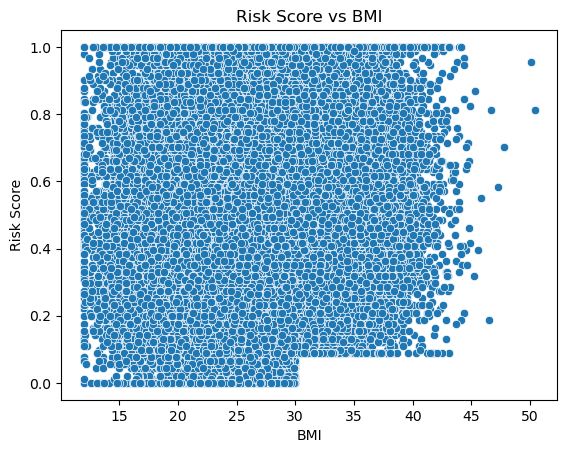

In [67]:
sns.scatterplot(data=analysis_data, x='bmi', y='risk_score')
plt.xlabel('BMI')
plt.ylabel('Risk Score')
plt.title('Risk Score vs BMI')
plt.show()

## Smoking

As seen in the graph below, current smokers have a much higher risk score on average than those who are not.
Surprisingly, former smokers have an almost identical risk score on average to those who never smoked

Text(0.5, 1.0, 'Risk Score by Smoking Status')

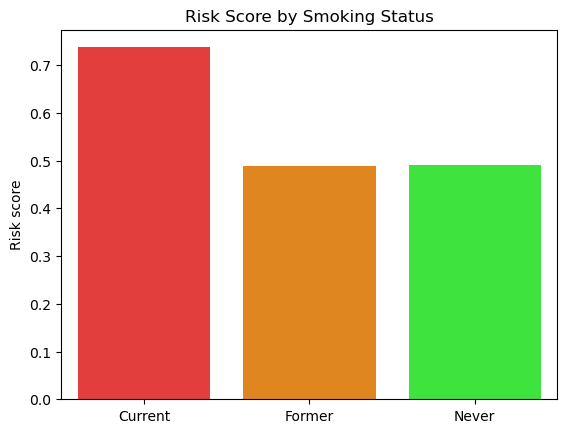

In [53]:
grouped = data.groupby('smoker', observed=True)['risk_score'].mean().reset_index()
grouped = data.groupby('smoker')['risk_score'].mean().reset_index()

sns.barplot(data=grouped, x='smoker', y='risk_score', palette=['#ff2222', '#ff8800', '#22ff22'])

plt.ylabel("Risk score")
plt.xlabel(None)
plt.title("Risk Score by Smoking Status")

## Alcohol
Surprisingly, alcohol seems to have an incredibly small effect on the risk score

In [54]:
data['alcohol_freq'].value_counts()

Occasional    45078
None          30083
Weekly        19833
Daily          5006
Name: alcohol_freq, dtype: int64

Text(0.5, 1.0, 'Risk Score by Alcohol Consumption Frequency')

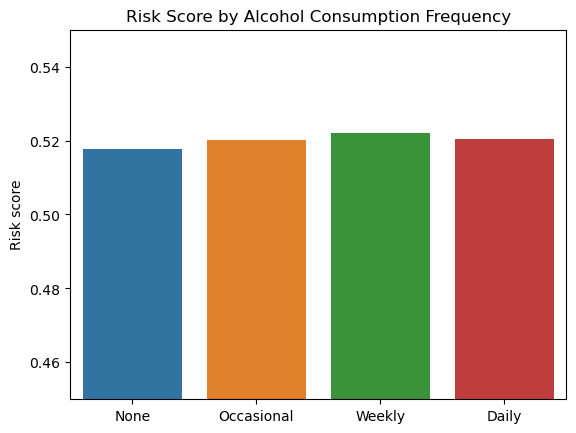

In [55]:
grouped = data.groupby('alcohol_freq',observed=True)['risk_score'].mean().reset_index()

sns.barplot(data=grouped, x='alcohol_freq', y='risk_score', order=['None', 'Occasional', 'Weekly', 'Daily'])
plt.ylim(0.45 , 0.55)
plt.ylabel("Risk score")
plt.xlabel(None)
plt.title("Risk Score by Alcohol Consumption Frequency")

## Sex

Men and women have basically identical risk scores on average. 'Other' has a very slightly lower mean risk score, likely due to statistical variation from the small population size

Text(0.5, 0, 'Sex')

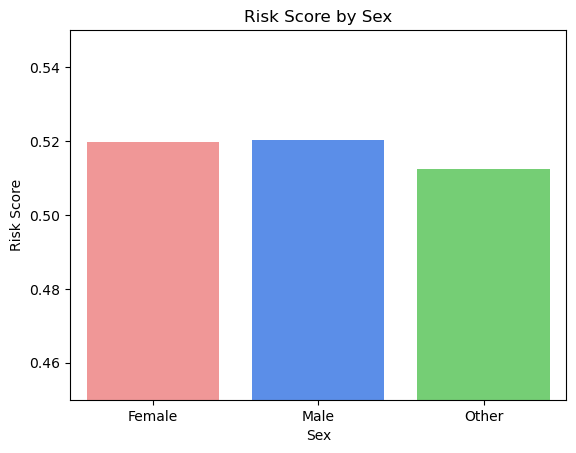

In [57]:
grouped = data.groupby('sex')['risk_score'].mean().reset_index()
sns.barplot(data=grouped, x='sex', y='risk_score', palette=['#ff8888', '#4488ff', '#66dd66'])
plt.ylim(0.45 , 0.55)
plt.title('Risk Score by Sex')
plt.ylabel('Risk Score')
plt.xlabel('Sex')

## Correlation Charts

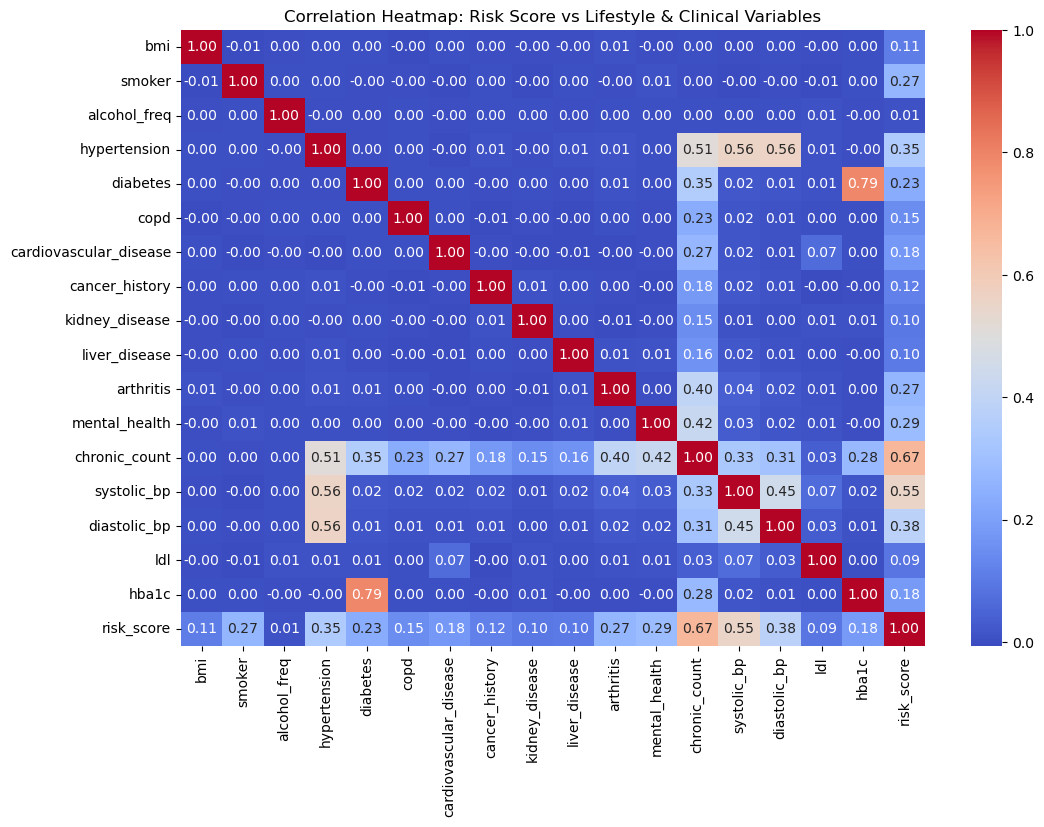

In [58]:
cols = [
    "bmi","smoker","alcohol_freq",
    "hypertension","diabetes","copd","cardiovascular_disease","cancer_history",
    "kidney_disease","liver_disease","arthritis","mental_health","chronic_count",
    "systolic_bp","diastolic_bp","ldl","hba1c","risk_score",
]

df_subset = analysis_data[cols]

# Keep only numeric columns for correlation
numeric_cols = df_subset.select_dtypes(include=["float64","int64"]).columns

corr = df_subset[numeric_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap: Risk Score vs Lifestyle & Clinical Variables")
plt.show()

Text(0, 0.5, 'Variable')

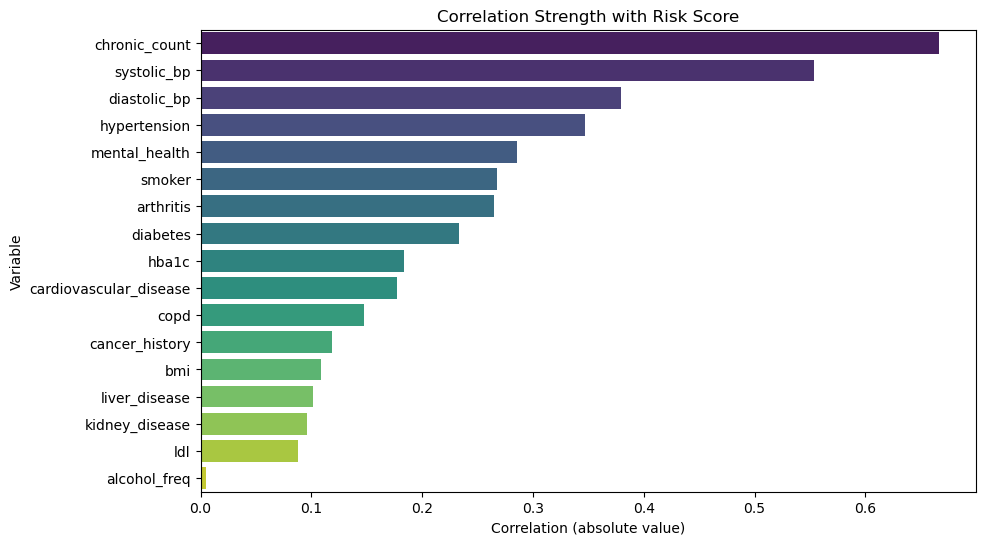

In [61]:
corrs = df_subset[numeric_cols].corr()["risk_score"].drop("risk_score")
corrs = corrs.abs().sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=corrs.values, y=corrs.index, palette="viridis")
plt.title("Correlation Strength with Risk Score")
plt.xlabel("Correlation (absolute value)")
plt.ylabel("Variable")

# Models(Regression/Catboost)

## Linear Regression

In [62]:
#default Linear Regression model with all encodings
test_data = analysis_data.drop(["risk_score", "is_high_risk"], axis=1)
data_train, data_test, risk_train, risk_test = train_test_split(test_data, analysis_data['risk_score'])
linearModel = LinearRegression()
linearModel.fit(data_train, risk_train)
risk_pred = linearModel.predict(data_test)

In [63]:
linearModel.score(data_test, risk_test)

0.936091390747187

### Testing the Linear Model's Error.

In [64]:
print("R² on test set:", r2_score(risk_test, risk_pred))

#mean squared error
mse = mean_squared_error(risk_test, risk_pred)
print("MSE on test set:", mse)

#root mean squared error
print("RMSE on test set:", np.sqrt(mse))

#mean absolute error
mae = mean_absolute_error(risk_test, risk_pred)
print("MAE on test set:", mae)

#AIC(negatives are better)
residual = risk_test - risk_pred
sse = np.sum(residual**2)
rows, cols = analysis_data.shape
aic = rows * np.log(sse/rows) + 2*(cols + 1)

print("The AIC is: ", aic)


R² on test set: 0.936091390747187
MSE on test set: 0.004021723402394939
RMSE on test set: 0.06341705923799162
MAE on test set: 0.04739862215291358
The AIC is:  -690101.9122276298


These results are very good with a R2 value of 0.94, the models coefficients and intercept should give us a good idea of the contribution that each feature has for risk score.

### Inspecting the Model's Coefficients and Intercept

In [ ]:
intercept = linearModel.intercept_
print("Intercept:", intercept)
coef_table = pd.Series(linearModel.coef_, index=data_train.columns)
coef_table.name = "Coefficients"
coef_table.sort_values(ascending=False)

Even though 0.93 is really good, because risk_score is most likely derived, it should be possible to get an r^2 even greater. At first we tried optimizing the model, by trying to remove colinearity, and scaling the data, but this did not effect the model.

While looking for a new model, we eventually discovered an advanced gradient boosting model that we can use.

## Catboost

In [ ]:
#This will take a while, so sit tight.



cat_data = data.drop(["risk_score", "is_high_risk"], axis=1)
cb_data_train, cb_data_test, cb_risk_train, cb_risk_test = train_test_split(cat_data, data['risk_score'])

model = CatBoostRegressor(verbose=50)
model.fit(cb_data_train, cb_risk_train, cat_features=obj_cols)
cb_risk_pred = model.predict(cb_data_test)
catboost_score = model.score(cb_data_test, cb_risk_test)
catboost_score

### Testing the Catboost Models Error

In [ ]:
print("R² on test set:", r2_score(cb_risk_test, cb_risk_pred))

#mean squared error
mse = mean_squared_error(cb_risk_test, cb_risk_pred)
print("MSE on test set:", mse)

#root mean squared error
print("RMSE on test set:", np.sqrt(mse))

#mean absolute error
mae = mean_absolute_error(cb_risk_test, cb_risk_pred)
print("MAE on test set:", mae)

#AIC(negatives are better)
residual = cb_risk_test - cb_risk_pred
sse = np.sum(residual**2)
rows, cols = data.shape
aic = rows * np.log(sse/rows) + 2*(cols + 1)

print("The AIC is: ", aic)

An R2 Value of 0.99 is extremely good and is exactly what we were looking for. The reason this model is so much better than linear regression is because this model uses gradient boosting. This allows the model to calculate how features affect the risk score exponentially, logarithmically etc. While linear reegresssion can only look at linear relations.

Catboost also uses advanced encoding to make our categories better represented.

In [ ]:
feature_importances = model.get_feature_importance()
feature_names = cb_data_train.columns


importance_data = pd.DataFrame({"Feature": feature_names,"Importance": feature_importances})
importance_data = importance_data.sort_values(by="Importance", ascending=False).reset_index(drop=True)


for _, row in importance_data.head(10).iterrows():
  print(f"{row['Feature']}: {row['Importance']:.5f}")

### Score with only 4 columns with the highest feature importance

In [ ]:
minimal_data = data[["total_claims_paid","age","smoker","bmi"]]

data_train, data_test, risk_train, risk_test = train_test_split(minimal_data, data['risk_score'], random_state=42)
model = CatBoostRegressor()
model.fit(data_train, risk_train, cat_features=["smoker"])

print(model.score(data_test, risk_test))

This Catboost model is significantly worse even though we provided the most influential features. The reason is that Catboost thrives off multiple features using feature interactions. If you remove most of the trees, then Catboost has less data to sharpen the model. Even if that column isn't useful.

## Models Graphed

In [ ]:
# Plot predicted vs actual
sns.scatterplot(x=risk_test, y=risk_pred)
plt.xlabel("Actual Risk Score")
plt.ylabel("Predicted Risk Score")
plt.title("Linear Regression: Predicted vs Actual Risk Score")
plt.show()

sns.scatterplot(x=cb_risk_test, y=cb_risk_pred)
plt.xlabel("Actual Risk Score")
plt.ylabel("Predicted Risk Score")
plt.title("CatBoost: Predicted vs Actual Risk Score")
plt.show()



# **Overall Conclusion**

While Correlations/linear regression give a good idea of what contributes to risk_score, CatBoost gives us the ultimate idea of what columns provide the most weight.